In [1]:
from pystac_client import Client
import geopandas as gpd
from datetime import datetime, UTC
import stackstac
import xarray as xr
from shapely.geometry import Point
from rasterio.errors import RasterioIOError
from planetary_computer import sign_inplace
import matplotlib.pyplot as plt
import sentinel2indices as s2i
from skimage.exposure import match_histograms
import math
from dask.diagnostics import ProgressBar
import rioxarray
import os
import hashlib
import pickle
from tqdm import tqdm


<Axes: >

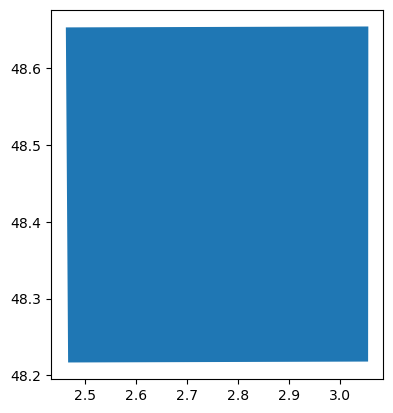

In [2]:

### CELL 1 Load Data

# Connect to Planetary Computer STAC
stac = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Load AOI from GeoJSON file
aoi_path = '/Users/thowe/MinersAI Dropbox/Tyler Howe/Sibelco_Stuff/DATACUBE/sibelco_ML_pilot_region.geojson'
aoi_gdf = gpd.read_file(aoi_path)

# Reproject to WGS84 if needed
if aoi_gdf.crs != "EPSG:4326":
    aoi_gdf = aoi_gdf.to_crs("EPSG:4326")

aoi_gdf.plot()


In [3]:

### CELL 2 Search STAC for low-cloud Sentinel-2 L2A items over AOI

# Broad date range — Sentinel-2 L2A available since mid-2017
start_date = "2017-06-28"
end_date = datetime.now(UTC).date().isoformat()

# Query STAC for clean Sentinel-2 L2A items
search = stac.search(
    collections=["sentinel-2-l2a"],
    intersects=aoi_gdf.geometry[0].__geo_interface__,
    datetime=f"{start_date}/{end_date}",
    query={"eo:cloud_cover": {"lt": 10}},  # low-cloud only
    sortby=["eo:cloud_cover"],  # sort by best quality
)

items = list(search.items())
print(f"Found {len(items)} items")


Found 335 items


In [4]:

### CELL 3 Setup caching system

# Create cache directory
cache_dir = '/Users/thowe/sentinel2_cache'
os.makedirs(cache_dir, exist_ok=True)

def create_cache_key(s2a_items, aoi_bounds, epsg):
    """Create a unique cache key based on input parameters"""
    key_data = {
        'item_ids': [item.id for item in s2a_items],
        'bounds': aoi_bounds.tolist(),
        'epsg': epsg,
        'bands': ["B01", "B02", "B03", "B04", "B06", "B07", "B08", "B8A", "B11", "B12"]
    }
    key_str = str(sorted(key_data.items()))
    return hashlib.md5(key_str.encode()).hexdigest()

def save_to_cache(data, cache_key, cache_dir):
    """Save processed data to cache"""
    cache_path = os.path.join(cache_dir, f"{cache_key}_composite.nc")
    print(f"Saving composite to cache: {cache_path}")
    with ProgressBar():
        data.to_netcdf(cache_path)
    return cache_path

def load_from_cache(cache_key, cache_dir):
    """Load processed data from cache"""
    cache_path = os.path.join(cache_dir, f"{cache_key}_composite.nc")
    if os.path.exists(cache_path):
        print(f"Loading composite from cache: {cache_path}")
        ds = xr.open_dataset(cache_path)
        return ds[list(ds.data_vars.keys())[0]]  # Return the first data variable
    return None


In [5]:

### CELL 4 Filter for S2A scenes and determine EPSG

# Keep only S2A scenes (from all items) and sign their URLs
s2a_items = [it for it in items if it.id.startswith("S2A")][:20]
if not s2a_items:
    raise RuntimeError("No S2A scenes found—check your STAC search criteria.")

print("Signing URLs...")
for it in tqdm(s2a_items, desc="Signing items"):
    sign_inplace(it)

print("Using these S2A items:", [it.id for it in s2a_items])

# Try EPSG from first item
item0 = s2a_items[0]
epsg = None
try:
    epsg = item0.assets["B02"].extra_fields["proj:epsg"]
    print(f"Using EPSG from first item: {epsg}")
except KeyError:
    pass

# Fall back to AOI centroid
if epsg is None:
    centroid: Point = aoi_gdf.geometry[0].centroid
    lon, lat = centroid.x, centroid.y
    zone = int((lon + 180) / 6) + 1
    epsg = 32600 + zone if lat >= 0 else 32700 + zone
    print(f"Using EPSG from AOI centroid: {epsg}")


Signing URLs...


Signing items: 100%|██████████| 20/20 [00:00<00:00, 25.61it/s]

Using these S2A items: ['S2A_MSIL2A_20250429T105701_R094_T31UDP_20250429T192814', 'S2A_MSIL2A_20250409T105701_R094_T31UDP_20250409T173716', 'S2A_MSIL2A_20250327T105041_R051_T31UEP_20250327T144118', 'S2A_MSIL2A_20250317T104811_R051_T31UEP_20250317T151957', 'S2A_MSIL2A_20250317T104811_R051_T31UDP_20250317T151957', 'S2A_MSIL2A_20230915T105701_R094_T31UDP_20241105T020528', 'S2A_MSIL2A_20230915T105701_R094_T31UDP_20230915T174938', 'S2A_MSIL2A_20230902T104631_R051_T31UEP_20241025T212417', 'S2A_MSIL2A_20230902T104631_R051_T31UEP_20230902T202513', 'S2A_MSIL2A_20230614T105031_R051_T31UEP_20240910T000108', 'S2A_MSIL2A_20230614T105031_R051_T31UEP_20230614T182838', 'S2A_MSIL2A_20230614T105031_R051_T31UDP_20240910T000108', 'S2A_MSIL2A_20230614T105031_R051_T31UDP_20230614T182836', 'S2A_MSIL2A_20230607T105621_R094_T31UDP_20241009T210215', 'S2A_MSIL2A_20230607T105621_R094_T31UDP_20230607T183221', 'S2A_MSIL2A_20230604T104621_R051_T31UEP_20240910T071227', 'S2A_MSIL2A_20230604T104621_R051_T31UEP_20230604

In [ ]:
### Cell 5: Process & cache raw histogram-matched stack (no cloud masking)

# Create base cache key and derive a raw-stack key
base_key = create_cache_key(s2a_items, aoi_gdf.total_bounds, epsg)
raw_cache_key = f"{base_key}_raw"

print(f"Cache key for raw stack: {raw_cache_key}")
raw_stack = load_from_cache(raw_cache_key, cache_dir)

if raw_stack is not None:
    print("✅ Loaded raw histogram-matched stack from cache!")
else:
    print("❌ No cached raw stack found. Processing raw data from scratch...")

    # ——— Build initial 10 m stack ———
    print("Creating initial stack…")
    stack = stackstac.stack(
        s2a_items,
        assets=["B01","B02","B03","B04","B06","B07","B08","B8A","B11","B12","SCL"],
        resolution=10,
        epsg=epsg,
        chunksize=2048,
        bounds_latlon=aoi_gdf.total_bounds,
        dtype="float64",
        rescale=True,
        errors_as_nodata=[RasterioIOError, RuntimeError],
    )
    print("Stack shape:", stack.shape)

    # Rechunk for per-scene processing
    print("Rechunking data…")
    stack_small = stack.chunk({"band": -1, "y": -1, "x": -1})
    ref_bands = ["B01","B02","B03","B04","B06","B07","B08","B8A","B11","B12"]
    ref = stack_small.isel(time=0).sel(band=ref_bands).chunk({"band": -1, "y": -1, "x": -1})

    # Define histogram-matching UFunc
    def match_to_ref(scene, ref):
        return xr.apply_ufunc(
            match_histograms,
            scene, ref,
            input_core_dims=[["band","y","x"],["band","y","x"]],
            output_core_dims=[["band","y","x"]],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[scene.dtype],
            dask_gufunc_kwargs={
                "allow_rechunk": True,
                "output_sizes": {"band": scene.sizes["band"], "y": scene.sizes["y"], "x": scene.sizes["x"]},
            },
        )

    # Apply histogram matching to each scene
    print("Histogram matching scenes…")
    matched = []
    for i, t in enumerate(tqdm(stack_small.time.values, desc="Processing scenes")):
        scene = stack_small.isel(time=i).sel(band=ref.band).chunk({"band": -1, "y": -1, "x": -1})
        m = match_to_ref(scene, ref).expand_dims(time=[t])
        matched.append(m)

    stack_norm = xr.concat(matched, dim="time")

    # Compute & cache the raw (histogram-matched) stack
    print("Computing full raw stack…")
    with ProgressBar():
        raw_stack = stack_norm.compute()

    # Attach CRS info and save
    
    # raw_stack currently has only reflectance bands
    raw_stack = raw_stack.rio.write_crs(f"EPSG:{epsg}")
    
    # —– Step A: extract and compute SCL from the original chunked stack_small —–
    print("Computing raw SCL…")
    with ProgressBar():
        scl = stack_small.sel(band="SCL").compute()
    
    # reshape SCL so its dims match raw_stack
    # (time, band=['SCL'], y, x)
    scl = scl.expand_dims(band=["SCL"]).transpose("time","band","y","x")
    
    # —– Step B: concatenate reflectance + SCL along the band axis —–
    raw_full = xr.concat([raw_stack, scl], dim="band")
    raw_full = raw_full.rio.write_crs(f"EPSG:{epsg}")
    
    # —– Step C: save the merged cube back to cache —–
    save_to_cache(raw_full, raw_cache_key, cache_dir)
    print("✅ Raw (reflectance + SCL) saved to cache!")

print("Raw stack shape:", raw_stack.shape)
print("Raw stack bands:", list(raw_stack.band.values))

Cache key for raw stack: 37ff6739bdbe43569f16662f2ea1f669_raw
❌ No cached raw stack found. Processing raw data from scratch...
Creating initial stack…
Stack shape: (20, 11, 4879, 4412)
Rechunking data…
Histogram matching scenes…


Processing scenes: 100%|██████████| 20/20 [00:01<00:00, 16.10it/s]

Computing full raw stack…
[                                        ] | 0% Completed | 129.21 us

[########################################] | 100% Completed | 408.89 s
Saving composite to cache: /Users/thowe/sentinel2_cache/37ff6739bdbe43569f16662f2ea1f669_raw_composite.nc
✅ Raw stack saved to cache for future runs!
Raw stack shape: (20, 10, 4879, 4412)
Raw stack bands: ['B01', 'B02', 'B03', 'B04', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']


In [7]:
### Cell 5.5: Cloud masking + median composite (loads raw from cache)

# Load raw_stack from cell 5 (or cache)
#raw_stack should already be in memory, but if you restart the kernel:
raw_stack = load_from_cache(raw_cache_key, cache_dir)

print("Applying cloud mask and creating median composite…")

# Extract Scene Classification Layer (SCL) and build valid mask
scl = raw_stack.sel(band="SCL")
valid = scl.isin([4, 5, 6])  # vegetation=4, bare soil=5, water=6

# Select only reflectance bands and apply mask
reflectance_bands = ["B01","B02","B03","B04","B06","B07","B08","B8A","B11","B12"]
clean = raw_stack.sel(band=reflectance_bands).where(valid)

# Compute median composite
print("Computing median…")
with ProgressBar():
    composite = clean.median(dim="time").compute()

# Add CRS metadata
composite = composite.rio.write_crs(f"EPSG:{epsg}")

# (Optional) cache the composited result under its own key
comp_cache_key = f"{base_key}_composite"
save_to_cache(composite, comp_cache_key, cache_dir)
print("✅ Composite saved to cache under key:", comp_cache_key)

print("Composite shape:", composite.shape)
print("Composite bands:", list(composite.band.values))

Loading composite from cache: /Users/thowe/sentinel2_cache/37ff6739bdbe43569f16662f2ea1f669_raw_composite.nc
Applying cloud mask and creating median composite…


KeyError: "'band' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({})"

In [ ]:
### CELL - Plot all composite bands in subplots

bands = list(composite.band.values)  # ['B01', 'B02', 'B03', 'B04', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
n = len(bands)
ncols = 5
nrows = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 8), squeeze=False)

for i, band in enumerate(bands):
    row = i // ncols
    col = i % ncols
    ax = axes[row, col]
    
    da = composite.sel(band=band)
    
    # Use appropriate colormap for different bands
    if band in ["B02", "B03", "B04"]:  # Blue, Green, Red
        cmap = "gray"
    elif band in ["B08", "B8A"]:  # NIR bands
        cmap = "RdYlGn"
    elif band in ["B11", "B12"]:  # SWIR bands
        cmap = "copper"
    else:
        cmap = "viridis"
    
    im = da.plot.imshow(
        ax=ax,
        cmap=cmap,
        add_colorbar=False,
        add_labels=False,
        origin="upper"
    )
    
    cbar = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
    cbar.set_label("Reflectance")
    ax.set_title(f"Band {band}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:

### CELL 6 Calculate spectral indices (now near-instant!)

print("Calculating spectral indices...")

# list out each function you want to try
funcs = [
    #s2i.hematite_goethite_s2, 
    #s2i.hematite_jarosite_s2, 
    #s2i.mixed_iron_s2,
    s2i.ndvi_s2
]

results = []
for fn in tqdm(funcs, desc="Computing indices"):
    da = fn(composite)
    # rename the DataArray to the function name
    da = da.rename(fn.__name__)
    # create a new length-1 "band" dimension, with its label equal to the function name
    da = da.expand_dims("band").assign_coords({"band": [fn.__name__]})
    results.append(da)

# now concat along that new "band" axis
indices = xr.concat(results, dim="band")

print("✅ Spectral indices computed!")
print("Index bands:", list(indices.band.values))


In [ ]:

### CELL 7 Plot the results

bands = list(indices.band.values)
n = len(bands)
ncols = min(4, n)
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), squeeze=False)

for i, band in enumerate(bands):
    ax = axes.flat[i]
    da = indices.sel(band=band)

    cmap = ("terrain" if "clay" in band
            else "RdBu"   if "iron" in band
            else "viridis")

    arr = da.squeeze().values
    im = da.plot.imshow(
        ax=ax,
        cmap=cmap,
        add_colorbar=False,
        add_labels=False,   
        origin="upper"
    )
    cbar = fig.colorbar(im, ax=ax,
                        orientation="vertical",
                        fraction=0.046, pad=0.04)
    cbar.set_label(band.replace("_"," ").title())
    ax.set_title(band.replace("_"," ").title())
    ax.axis("off")

# disable any empty subplots
for j in range(n, nrows * ncols):
    r, c = divmod(j, ncols)
    axes[r][c].axis("off")

plt.tight_layout()
plt.show()


In [ ]:

### CELL 8 Export the results

index_names = list(indices.band.values)
print("Will export these indices:", index_names)

output_dir = '/Users/thowe/Downloads'
os.makedirs(output_dir, exist_ok=True)

# loop through names and export
for name in tqdm(index_names, desc="Exporting indices"):
    da = indices.sel(band=name)
    da.rio.to_raster(os.path.join(output_dir, f"{name}.tif"))

print("✅ Export completed!")


In [ ]:

### OPTIONAL: Cache management utilities

def list_cached_composites(cache_dir):
    """List all cached composites"""
    cache_files = [f for f in os.listdir(cache_dir) if f.endswith('_composite.nc')]
    print(f"Found {len(cache_files)} cached composites:")
    for f in cache_files:
        cache_path = os.path.join(cache_dir, f)
        size_mb = os.path.getsize(cache_path) / (1024*1024)
        print(f"  {f}: {size_mb:.1f} MB")

def clear_cache(cache_dir):
    """Clear all cached files"""
    import shutil
    if os.path.exists(cache_dir):
        shutil.rmtree(cache_dir)
        os.makedirs(cache_dir, exist_ok=True)
        print("Cache cleared!")


In [ ]:

# Uncomment to use:
# list_cached_composites(cache_dir)
# clear_cache(cache_dir)